In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%run setup_notebooks.py

In [3]:
from toolbox.wandb_export import process_runs

In [4]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [5]:
import wandb

In [6]:
from itertools import product

def format_metric(mean, std):
    return f'{mean:.3} ± {std:.3}'

def process_metrics(df, test_id, hyperparams, include_test=True):
    prefixes = ['val', 'train']
    if include_test:
        prefixes.insert(0, 'test')
        
    labels = [
        (tpl, '.'.join(tpl)) 
        for tpl in product(prefixes, ['f1-score', 'accuracy', 'precision', 'recall'])
    ]
    data = {
        tpl: (df[col].mean(), df[col].std()) for tpl, col in labels
    }
    data = {
        tpl: [format_metric(*vals)] for tpl, vals in data.items()
    }
    
    if len(hyperparams) > 0:
        hyp = df[hyperparams]
        assert (hyp.nunique() == 1).all()
        hyp = hyp.iloc[[0]]
        hyp.index = [test_id]
    else:
        hyp = None
    
    
    return pd.DataFrame(data, index=[test_id]), hyp

In [96]:
files = Path('data').glob('wandb_export_test*.csv')
dfs = []
for file in files:
    df = pd.read_csv(file)
    test_id = file.stem.split('-')[-1]
    df['test_id'] = test_id
    dfs.append(df)
    
dfs = pd.concat(dfs)

In [86]:
hyperparams = [
    'dataset.name', 'epochs', 'loss.weight', 'model.name', 'model.type',
    'num_equiv', 'num_gin', 'num_hidden_dim', 'optimizer.lr',
    'dataset.node_feat.transform', 'dataset.standardize', 'dataset.sampler'
]

In [97]:
metrics = [
    f'{t}.{i}.{m}'
    for t in ('test', 'val', 'train')
    for i in ('0', '1')
    for m in ('f1-score', )
]
metrics.insert(-1, 'train.1.auc')
metrics.insert(4, 'val.1.auc')
metrics.insert(2, 'test.1.auc')


df = dfs.groupby('test_id').agg(['mean', 'std'])[metrics]
df

test.0.f1-score           test.1.f1-score           test.1.auc  \
                   mean       std            mean       std       mean   
test_id                                                                  
0mw7b7         0.394682  0.230544        0.321894  0.181572   0.428030   
5ira58         0.349242  0.081613        0.413725  0.163118   0.415909   
6bijz4         0.243814  0.083943        0.405771  0.065195   0.361869   
8xb6tn         0.549090  0.104841        0.371667  0.091591   0.437500   
94oie3         0.473961  0.118568        0.383810  0.080924   0.431818   
9dhm3w         0.514851  0.161368        0.330591  0.204654   0.418750   
bx65z07        0.425072  0.177045        0.401491  0.109397   0.455682   
n097d1         0.488453  0.106548        0.326130  0.111447   0.468182   
ptot6k         0.411503  0.212784        0.291825  0.200703   0.411364   
rqp0m6         0.502944  0.117272        0.317327  0.119673   0.415909   
rxyubv         0.396548  0.089480        0.342767  0.098594   0.404545   
v7z5xw         0.523878  0.037339        0.433858  0.070749   0.419318   
vc5ux5         0.210513  0.108346        0.480240  0.125098   0.446591   
xa0yb8         0.431757  0.188341        0.365581  0.034317   0.366477   
zo50uk         0.364799  0.068851        0.403691  0.067164   0.390909   

                  val.0.f1-score           val.1.f1-score           val.1.auc  \
              std           mean       std           mean       std      mean   
test_id                                                                         
0mw7b7   0.131710       0.585963  0.111772       0.471206  0.264239  0.596850   
5ira58   0.048612       0.353136  0.196159       0.491597  0.090162  0.555691   
6bijz4   0.117144       0.410718  0.106271       0.541526  0.080689  0.551684   
8xb6tn   0.084083       0.600079  0.051222       0.466663  0.085129  0.567490   
94oie3   0.108104       0.669713  0.105095       0.606750  0.115017  0.670195   
9dhm3w   0.111079       0.645523  0.071481       0.504087  0.286627  0.644118   
bx65z07  0.133396       0.483620  0.103644       0.459890  0.087374  0.497551   
n097d1   0.108818       0.642891  0.085247       0.527224  0.051399  0.630906   
ptot6k   0.081708       0.568504  0.082450       0.461141  0.261603  0.550125   
rqp0m6   0.118531       0.581681  0.103745       0.412308  0.100355  0.476537   
rxyubv   0.062033       0.548886  0.050733       0.507167  0.110140  0.573118   
v7z5xw   0.092003       0.513464  0.118936       0.445197  0.159838  0.516355   
vc5ux5   0.136058       0.398873  0.119620       0.559004  0.074178  0.541627   
xa0yb8   0.069877       0.638157  0.068615       0.535994  0.157337  0.725292   
zo50uk   0.010164       0.651892  0.052095       0.609377  0.068170  0.733497   

                  train.0.f1-score           train.1.auc            \
              std             mean       std        mean       std   
test_id                                                              
0mw7b7   0.090220         0.670662  0.041181    0.666347  0.137260   
5ira58   0.096816         0.579848  0.116626    0.658756  0.031806   
6bijz4   0.066381         0.583432  0.132331    0.693638  0.054788   
8xb6tn   0.071919         0.923816  0.015223    0.934953  0.016981   
94oie3   0.137537         0.809473  0.025151    0.830859  0.036284   
9dhm3w   0.174862         0.764508  0.038140    0.756492  0.127361   
bx65z07  0.095003         0.813411  0.042115    0.826942  0.034119   
n097d1   0.096207         0.891445  0.126984    0.871843  0.109552   
ptot6k   0.032411         0.658368  0.087080    0.681795  0.123680   
rqp0m6   0.055640         0.900738  0.025966    0.874388  0.023910   
rxyubv   0.111563         0.584188  0.058965    0.675350  0.023943   
v7z5xw   0.102994         0.947403  0.016915    0.947916  0.013567   
vc5ux5   0.107085         0.610658  0.087051    0.699177  0.047187   
xa0yb8   0.031472         0.741985  0.020997    0.786072  0.005868   
zo50uk   0.058575         

In [99]:
df_config = []
for test_id, sub in dfs.groupby('test_id'):
    assert ((sub[hyperparams].nunique() == 1) | (sub[hyperparams].nunique() == 0)).all()
    # Pick any
    item = sub[hyperparams].iloc[0]
    df_config.append(item.rename(test_id))
    
df_config = pd.DataFrame(df_config).sort_values('dataset.name')
df_config

,dataset.name,epochs,loss.weight,model.name,model.type,num_equiv,num_gin,num_hidden_dim,optimizer.lr,dataset.node_feat.transform,dataset.standardize,dataset.sampler
5ira58,CoordToCnc,130,0.650000,EGNN_GIN_KNN5,Equiv,3.0,0,5,0.004000,NaN,NaN,NaN
ptot6k,CoordToCnc_NOISE4e-2,90,0.650000,EGNN_GIN_KNN5,Equiv,3.0,0,8,0.004000,NaN,NaN,NaN
rxyubv,CoordToCnc_NOISE4e-2,90,0.650000,EGNN_GIN_KNN5,Equiv,5.0,0,5,0.004000,NaN,NaN,NaN
bx65z07,CoordToCnc_coarsened_r0.7_k5_NOISE4e-2,70,0.572972,EGNN_GIN_KNN5,Equiv,4.0,1,8,0.001016,NaN,NaN,NaN
vc5ux5,CoordToCnc_only_randdiff_t8_c3,130,0.650000,EGNN,Equiv,3.0,0,5,0.004000,NaN,NaN,NaN
0mw7b7,CoordToCnc_only_randdiff_t8_c6,130,0.650000,EGNN,Equiv,3.0,0,5,0.004000,NaN,NaN,NaN
6bijz4,CoordToCnc_only_randdiff_t8_c6,130,0.650000,EGNN,Equiv,3.0,0,5,0.004000,NaN,NaN,NaN
8xb6tn,CoordToCnc_rot,120,0.580000,GIN_rot,GIN,NaN,3,8,0.000500,NaN,NaN,NaN
rqp0m6,CoordToCnc_rot,120,0.580000,GIN_rot,GIN,NaN,3,8,0.000500,NaN,NaN,artery
94oie3,WssToCnc,130,0.570000,EGNN,Equiv,5.0,0,5,0.004000,fourier,NaN,NaN


In [100]:
df.loc[df_config.index]

test.0.f1-score           test.1.f1-score           test.1.auc  \
                   mean       std            mean       std       mean   
5ira58         0.349242  0.081613        0.413725  0.163118   0.415909   
ptot6k         0.411503  0.212784        0.291825  0.200703   0.411364   
rxyubv         0.396548  0.089480        0.342767  0.098594   0.404545   
bx65z07        0.425072  0.177045        0.401491  0.109397   0.455682   
vc5ux5         0.210513  0.108346        0.480240  0.125098   0.446591   
0mw7b7         0.394682  0.230544        0.321894  0.181572   0.428030   
6bijz4         0.243814  0.083943        0.405771  0.065195   0.361869   
8xb6tn         0.549090  0.104841        0.371667  0.091591   0.437500   
rqp0m6         0.502944  0.117272        0.317327  0.119673   0.415909   
94oie3         0.473961  0.118568        0.383810  0.080924   0.431818   
zo50uk         0.364799  0.068851        0.403691  0.067164   0.390909   
9dhm3w         0.514851  0.161368        0.330591  0.204654   0.418750   
xa0yb8         0.431757  0.188341        0.365581  0.034317   0.366477   
n097d1         0.488453  0.106548        0.326130  0.111447   0.468182   
v7z5xw         0.523878  0.037339        0.433858  0.070749   0.419318   

                  val.0.f1-score           val.1.f1-score           val.1.auc  \
              std           mean       std           mean       std      mean   
5ira58   0.048612       0.353136  0.196159       0.491597  0.090162  0.555691   
ptot6k   0.081708       0.568504  0.082450       0.461141  0.261603  0.550125   
rxyubv   0.062033       0.548886  0.050733       0.507167  0.110140  0.573118   
bx65z07  0.133396       0.483620  0.103644       0.459890  0.087374  0.497551   
vc5ux5   0.136058       0.398873  0.119620       0.559004  0.074178  0.541627   
0mw7b7   0.131710       0.585963  0.111772       0.471206  0.264239  0.596850   
6bijz4   0.117144       0.410718  0.106271       0.541526  0.080689  0.551684   
8xb6tn   0.084083       0.600079  0.051222       0.466663  0.085129  0.567490   
rqp0m6   0.118531       0.581681  0.103745       0.412308  0.100355  0.476537   
94oie3   0.108104       0.669713  0.105095       0.606750  0.115017  0.670195   
zo50uk   0.010164       0.651892  0.052095       0.609377  0.068170  0.733497   
9dhm3w   0.111079       0.645523  0.071481       0.504087  0.286627  0.644118   
xa0yb8   0.069877       0.638157  0.068615       0.535994  0.157337  0.725292   
n097d1   0.108818       0.642891  0.085247       0.527224  0.051399  0.630906   
v7z5xw   0.092003       0.513464  0.118936       0.445197  0.159838  0.516355   

                  train.0.f1-score           train.1.auc            \
              std             mean       std        mean       std   
5ira58   0.096816         0.579848  0.116626    0.658756  0.031806   
ptot6k   0.032411         0.658368  0.087080    0.681795  0.123680   
rxyubv   0.111563         0.584188  0.058965    0.675350  0.023943   
bx65z07  0.095003         0.813411  0.042115    0.826942  0.034119   
vc5ux5   0.107085         0.610658  0.087051    0.699177  0.047187   
0mw7b7   0.090220         0.670662  0.041181    0.666347  0.137260   
6bijz4   0.066381         0.583432  0.132331    0.693638  0.054788   
8xb6tn   0.071919         0.923816  0.015223    0.934953  0.016981   
rqp0m6   0.055640         0.900738  0.025966    0.874388  0.023910   
94oie3   0.137537         0.809473  0.025151    0.830859  0.036284   
zo50uk   0.058575         0.741393  0.024901    0.773559  0.024193   
9dhm3w   0.174862         0.764508  0.038140    0.756492  0.127361   
xa0yb8   0.031472         0.741985  0.020997    0.786072  0.005868   
n097d1   0.096207         0.891445  0.126984    0.871843  0.109552   
v7z5xw   0.102994         0.947403  0.016915    0.947916  0.013567   

        train.1.f1-score            
                    mean       std  
5ira58          0.601470  0.039380  
ptot6k          0.546909  0.306960  
rxyubv          0.627775  0.0241

In [48]:
def to_tex(df, float_format="{:0.2f}".format):
    metrics = df.columns.get_level_values(0)
    out = dict()
    for tid, row in df.iterrows():
        resrow = {
            m: f"{row[(m, 'mean')]:.3} ± {row[(m, 'std')]:.3}"
            for m in metrics
        }
        out[tid] = resrow
    
    out = pd.DataFrame(out).T
    tex = out.to_latex()
    tex = tex.replace('midrule', 'hline').replace('toprule', 'hline').replace('bottomrule', 'hline')
    return tex

In [101]:
print(to_tex(df.loc[df_config.index]))

\begin{tabular}{llllllllll}
\hline
{} & test.0.f1-score & test.1.f1-score &      test.1.auc &  val.0.f1-score &  val.1.f1-score &       val.1.auc & train.0.f1-score &      train.1.auc & train.1.f1-score \\
\hline
5ira58  &  0.349 ± 0.0816 &   0.414 ± 0.163 &  0.416 ± 0.0486 &   0.353 ± 0.196 &  0.492 ± 0.0902 &  0.556 ± 0.0968 &     0.58 ± 0.117 &   0.659 ± 0.0318 &   0.601 ± 0.0394 \\
ptot6k  &   0.412 ± 0.213 &   0.292 ± 0.201 &  0.411 ± 0.0817 &  0.569 ± 0.0824 &   0.461 ± 0.262 &   0.55 ± 0.0324 &   0.658 ± 0.0871 &    0.682 ± 0.124 &    0.547 ± 0.307 \\
rxyubv  &  0.397 ± 0.0895 &  0.343 ± 0.0986 &   0.405 ± 0.062 &  0.549 ± 0.0507 &    0.507 ± 0.11 &   0.573 ± 0.112 &    0.584 ± 0.059 &   0.675 ± 0.0239 &   0.628 ± 0.0242 \\
bx65z07 &   0.425 ± 0.177 &   0.401 ± 0.109 &   0.456 ± 0.133 &   0.484 ± 0.104 &   0.46 ± 0.0874 &   0.498 ± 0.095 &   0.813 ± 0.0421 &   0.827 ± 0.0341 &   0.777 ± 0.0469 \\
vc5ux5  &   0.211 ± 0.108 &    0.48 ± 0.125 &   0.447 ± 0.136 &    0.399 ± 0.12 &  

In [102]:
cols = ['dataset.name', 'model.type', 'num_equiv', 'num_hidden_dim', 'dataset.node_feat.transform', 'dataset.standardize']
df_latex = df_config[cols]
print(df_latex.to_latex(na_rep='-'))

\begin{tabular}{lllrrll}
\toprule
{} &                            dataset.name & model.type &  num\_equiv &  num\_hidden\_dim & dataset.node\_feat.transform & dataset.standardize \\
\midrule
5ira58  &                              CoordToCnc &      Equiv &        3.0 &               5 &                           - &                   - \\
ptot6k  &                    CoordToCnc\_NOISE4e-2 &      Equiv &        3.0 &               8 &                           - &                   - \\
rxyubv  &                    CoordToCnc\_NOISE4e-2 &      Equiv &        5.0 &               5 &                           - &                   - \\
bx65z07 &  CoordToCnc\_coarsened\_r0.7\_k5\_NOISE4e-2 &      Equiv &        4.0 &               8 &                           - &                   - \\
vc5ux5  &          CoordToCnc\_only\_randdiff\_t8\_c3 &      Equiv &        3.0 &               5 &                           - &                   - \\
0mw7b7  &          CoordToCnc\_only\_randdiff\_t8\_c6 

2022-04-25 10:27:34,503 [_axes] [WARNING] *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='(val.1.f1-score, mean)', ylabel='(val.1.auc, mean)'>

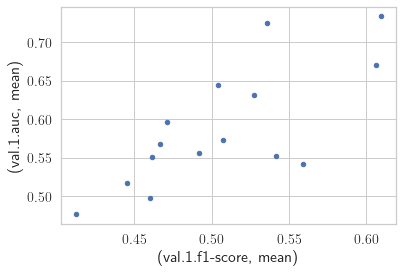

In [106]:
df.plot(x=('val.1.f1-score', 'mean'), y=('val.1.auc', 'mean'), kind='scatter')

In [107]:
df

test.0.f1-score           test.1.f1-score           test.1.auc  \
                   mean       std            mean       std       mean   
test_id                                                                  
0mw7b7         0.394682  0.230544        0.321894  0.181572   0.428030   
5ira58         0.349242  0.081613        0.413725  0.163118   0.415909   
6bijz4         0.243814  0.083943        0.405771  0.065195   0.361869   
8xb6tn         0.549090  0.104841        0.371667  0.091591   0.437500   
94oie3         0.473961  0.118568        0.383810  0.080924   0.431818   
9dhm3w         0.514851  0.161368        0.330591  0.204654   0.418750   
bx65z07        0.425072  0.177045        0.401491  0.109397   0.455682   
n097d1         0.488453  0.106548        0.326130  0.111447   0.468182   
ptot6k         0.411503  0.212784        0.291825  0.200703   0.411364   
rqp0m6         0.502944  0.117272        0.317327  0.119673   0.415909   
rxyubv         0.396548  0.089480        0.342767  0.098594   0.404545   
v7z5xw         0.523878  0.037339        0.433858  0.070749   0.419318   
vc5ux5         0.210513  0.108346        0.480240  0.125098   0.446591   
xa0yb8         0.431757  0.188341        0.365581  0.034317   0.366477   
zo50uk         0.364799  0.068851        0.403691  0.067164   0.390909   

                  val.0.f1-score           val.1.f1-score           val.1.auc  \
              std           mean       std           mean       std      mean   
test_id                                                                         
0mw7b7   0.131710       0.585963  0.111772       0.471206  0.264239  0.596850   
5ira58   0.048612       0.353136  0.196159       0.491597  0.090162  0.555691   
6bijz4   0.117144       0.410718  0.106271       0.541526  0.080689  0.551684   
8xb6tn   0.084083       0.600079  0.051222       0.466663  0.085129  0.567490   
94oie3   0.108104       0.669713  0.105095       0.606750  0.115017  0.670195   
9dhm3w   0.111079       0.645523  0.071481       0.504087  0.286627  0.644118   
bx65z07  0.133396       0.483620  0.103644       0.459890  0.087374  0.497551   
n097d1   0.108818       0.642891  0.085247       0.527224  0.051399  0.630906   
ptot6k   0.081708       0.568504  0.082450       0.461141  0.261603  0.550125   
rqp0m6   0.118531       0.581681  0.103745       0.412308  0.100355  0.476537   
rxyubv   0.062033       0.548886  0.050733       0.507167  0.110140  0.573118   
v7z5xw   0.092003       0.513464  0.118936       0.445197  0.159838  0.516355   
vc5ux5   0.136058       0.398873  0.119620       0.559004  0.074178  0.541627   
xa0yb8   0.069877       0.638157  0.068615       0.535994  0.157337  0.725292   
zo50uk   0.010164       0.651892  0.052095       0.609377  0.068170  0.733497   

                  train.0.f1-score           train.1.auc            \
              std             mean       std        mean       std   
test_id                                                              
0mw7b7   0.090220         0.670662  0.041181    0.666347  0.137260   
5ira58   0.096816         0.579848  0.116626    0.658756  0.031806   
6bijz4   0.066381         0.583432  0.132331    0.693638  0.054788   
8xb6tn   0.071919         0.923816  0.015223    0.934953  0.016981   
94oie3   0.137537         0.809473  0.025151    0.830859  0.036284   
9dhm3w   0.174862         0.764508  0.038140    0.756492  0.127361   
bx65z07  0.095003         0.813411  0.042115    0.826942  0.034119   
n097d1   0.096207         0.891445  0.126984    0.871843  0.109552   
ptot6k   0.032411         0.658368  0.087080    0.681795  0.123680   
rqp0m6   0.055640         0.900738  0.025966    0.874388  0.023910   
rxyubv   0.111563         0.584188  0.058965    0.675350  0.023943   
v7z5xw   0.102994         0.947403  0.016915    0.947916  0.013567   
vc5ux5   0.107085         0.610658  0.087051    0.699177  0.047187   
xa0yb8   0.031472         0.741985  0.020997    0.786072  0.005868   
zo50uk   0.058575         

# Explore predictions

In [113]:
df = pd.read_json('data/pred-3eyu0aga.json')
df

,file,type,g_x,pred,y
0,CHUV01_LAD.pt,train,"[[1.0, 0.0, 0.0]]","[0.20732200145721402, 0.7926779389381401]",0
1,CHUV01_LCX.pt,train,"[[0.0, 1.0, 0.0]]","[0.6452839970588681, 0.35471603274345404]",1
2,CHUV03_LAD.pt,train,"[[1.0, 0.0, 0.0]]","[0.072567626833915, 0.9274323582649231]",1
3,CHUV03_LCX.pt,train,"[[0.0, 1.0, 0.0]]","[0.82975548505783, 0.17024452984333002]",0
4,CHUV03_RCA.pt,train,"[[0.0, 0.0, 1.0]]","[0.5003668665885921, 0.499633133411407]",0
...,...,...,...,...,...
183,OLV041_LAD.pt,test,"[[1.0, 0.0, 0.0]]","[0.172797843813896, 0.8272021412849421]",0
184,OLV041_LCX.pt,test,"[[0.0, 1.0, 0.0]]","[0.86091148853302, 0.139088556170463]",0
185,OLV041_RCA.pt,test,"[[0.0, 0.0, 1.0]]","[0.41511708498001104, 0.584882915019989]",1
186,OLV048_LAD.pt,test,"[[1.0, 0.0, 0.0]]","[0.083544924855232, 0.9164550304412841]",1


In [114]:
from sklearn.metrics import roc_curve

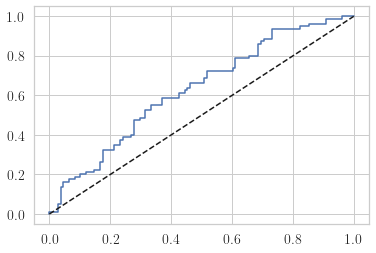

In [126]:
fpr, tpr, thres = roc_curve(df.y, df.pred.apply(lambda e: e[1]))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--k');

# Curves

In [63]:
from toolbox.wandb_export import concat_runs_history

In [71]:
r = wandb.Api().runs('mazeller/egnn-mi', filters={'tags': {'$in': ['test-5ira58']}})
len(r)

5

In [72]:
df_hist = concat_runs_history(r)
df_hist

2022-04-24 16:56:18,012 [wandb_export] [INFO] extracting runs history


,id,val.macro avg.recall,val.epoch,train.macro avg.f1-score,train.loss,train.weighted avg.f1-score,train.0.recall,val.0.recall,_step,train.epoch,...,test.1.f1-score,test.1.support,test.macro avg.f1-score,test.macro avg.precision,test.macro avg.recall,test_loss,test.macro avg.support,test.0.precision,test.1.precision,test.0.recall
step,,,,,,,,,,,,,,,,,,,,,
0,12t3n9tw,0.500000,1.0,0.468258,0.672606,0.451073,0.233766,0.000000,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12t3n9tw,0.500000,2.0,0.300518,0.683074,0.258223,0.000000,0.000000,1,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12t3n9tw,0.500000,3.0,0.300518,0.680984,0.258223,0.000000,0.000000,2,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12t3n9tw,0.500000,4.0,0.300518,0.676993,0.258223,0.000000,0.000000,3,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12t3n9tw,0.500000,5.0,0.300518,0.676124,0.258223,0.000000,0.000000,4,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,13tflzdw,0.480952,127.0,0.437743,0.686475,0.415155,0.184211,0.095238,126,127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,13tflzdw,0.633333,128.0,0.536842,0.650030,0.528230,0.360000,0.666667,127,128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,13tflzdw,0.628571,129.0,0.628254,0.649381,0.630175,0.586667,0.523810,128,129.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
def plot_curves(df_hist):
    ids = df_hist.id.unique()
    df_plot = df_hist.reset_index()
    
    metrics = ['loss', '1.f1-score', '0.f1-score']
    _, ax = plt.subplots(2, len(metrics), figsize=(len(metrics) * 4.5 + 0.5, 6),
                         sharex=True, sharey='col')
    
    for arow, m in zip(ax.T, metrics):
        for a, prefix in zip(arow, ['train', 'val']):
            sns.lineplot(x='train.epoch', y=f'{prefix}.{m}', ax=a, hue='id', data=df_plot, alpha=.8)
            
    for a in ax.ravel()[:-1]:
        a.legend_.remove()
        
    labels = [f'fold {i+1}' for i in range(len(ids))]
    plt.legend(labels, bbox_to_anchor=(.2, -.3), ncol=len(ids))
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25)

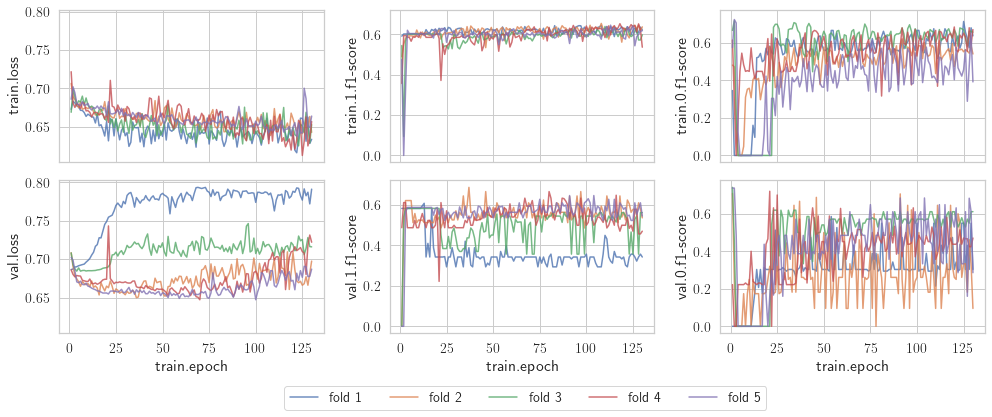

In [75]:
plot_curves(df_hist)
plt.savefig('figs/learning-curves-test-5ira58.pdf', bbox_inches='tight')

2022-04-24 16:55:12,260 [wandb_export] [INFO] extracting runs history


len 5


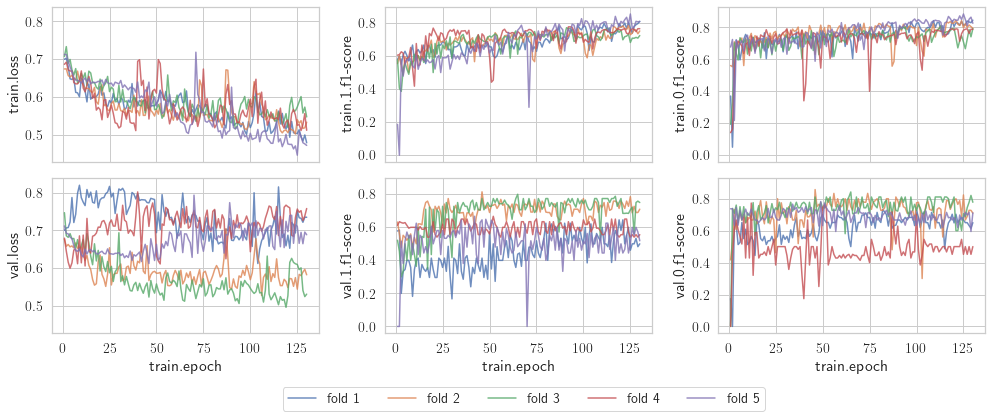

In [69]:
r = wandb.Api().runs('mazeller/egnn-mi', filters={'tags': {'$in': ['test-94oie3']}})
print('len', len(r))

df_hist = concat_runs_history(r)
plot_curves(df_hist)
plt.savefig('figs/learning-curves-test-94oie3.pdf', bbox_inches='tight')

2022-04-24 17:30:43,523 [wandb_export] [INFO] extracting runs history


len 5


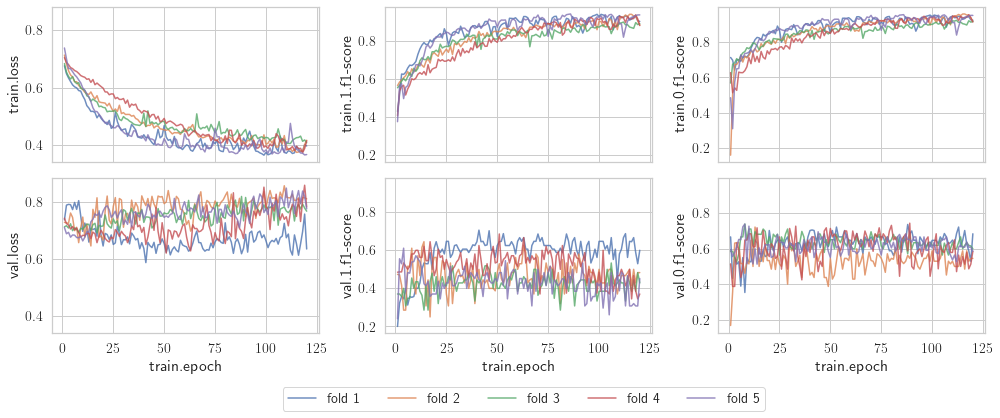

In [91]:
r = wandb.Api().runs('mazeller/egnn-mi', filters={'tags': {'$in': ['test-8xb6tn']}})
print('len', len(r))

df_hist = concat_runs_history(r)
plot_curves(df_hist)
plt.savefig('figs/learning-curves-test-8xb6tn.pdf', bbox_inches='tight')